### 5- Formulate the proposed VRP problem and solve its mathematical model using Gurobi and illustrate your solution.

In [1]:
import pandas as pd
import numpy as np
from gurobipy import *

In [2]:
#To read different sheets in an excel file we can you this block of code
xls = pd.ExcelFile('real_distances_30_customers.xlsx') 
df_distance_matrix = pd.read_excel(xls, 'distance', header=None) # header=None make first row not the header
df_demand = pd.read_excel(xls, 'demand', index_col=0) # col= 0 because in data we have the indexes

find list of nodes

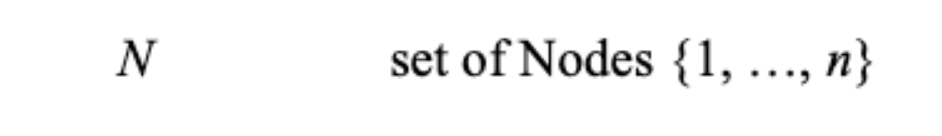

In [4]:
nodes = list(range(df_distance_matrix.shape[0])) 

Build distance matrix

In [6]:
dist = [[round(float(df_distance_matrix[j][i]), 2) for j in nodes] for i in nodes] # to convert pd dataframe a python's built in list

In [7]:
origin = 0 # Our origin is depo and the depo is node 0

build demand matrix

In [15]:
demand = df_demand.values.tolist() # this code gives demands as lists in a list
demand

[[0],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10],
 [10]]

to make it not lists in a list I used following link, https://stackoverflow.com/questions/716477/join-list-of-lists-in-python#:~:text=x%20%3D%20%5B%5B%22a%22%2C%22b%22%5D%2C%20%5B%22c%22%5D%5D%0A%0Aresult%20%3D%20sum(x%2C%20%5B%5D)

In [16]:
demand = sum(demand, []) # I implement the line of code that used in the link above
print(demand)

[0, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [17]:
veh_cap = 120 #Vehicle Capacity
k = int(np.ceil(np.sum(demand)/veh_cap)) # number of vehicles
                                        # this line of code is finding the min # of vehicle that we have to use
                                             # np.sum(demand) = 404, n_max=150, we take the ceiling because 
                                            #vehicle # is integer and we need to satisfy the demand from customers
                                            #If we use floor from divition then we can not satisfy it

In [18]:
k

3

In [19]:
#Create a new model
vrp = Model("vrp_model")

Set parameter Username


Create Variables

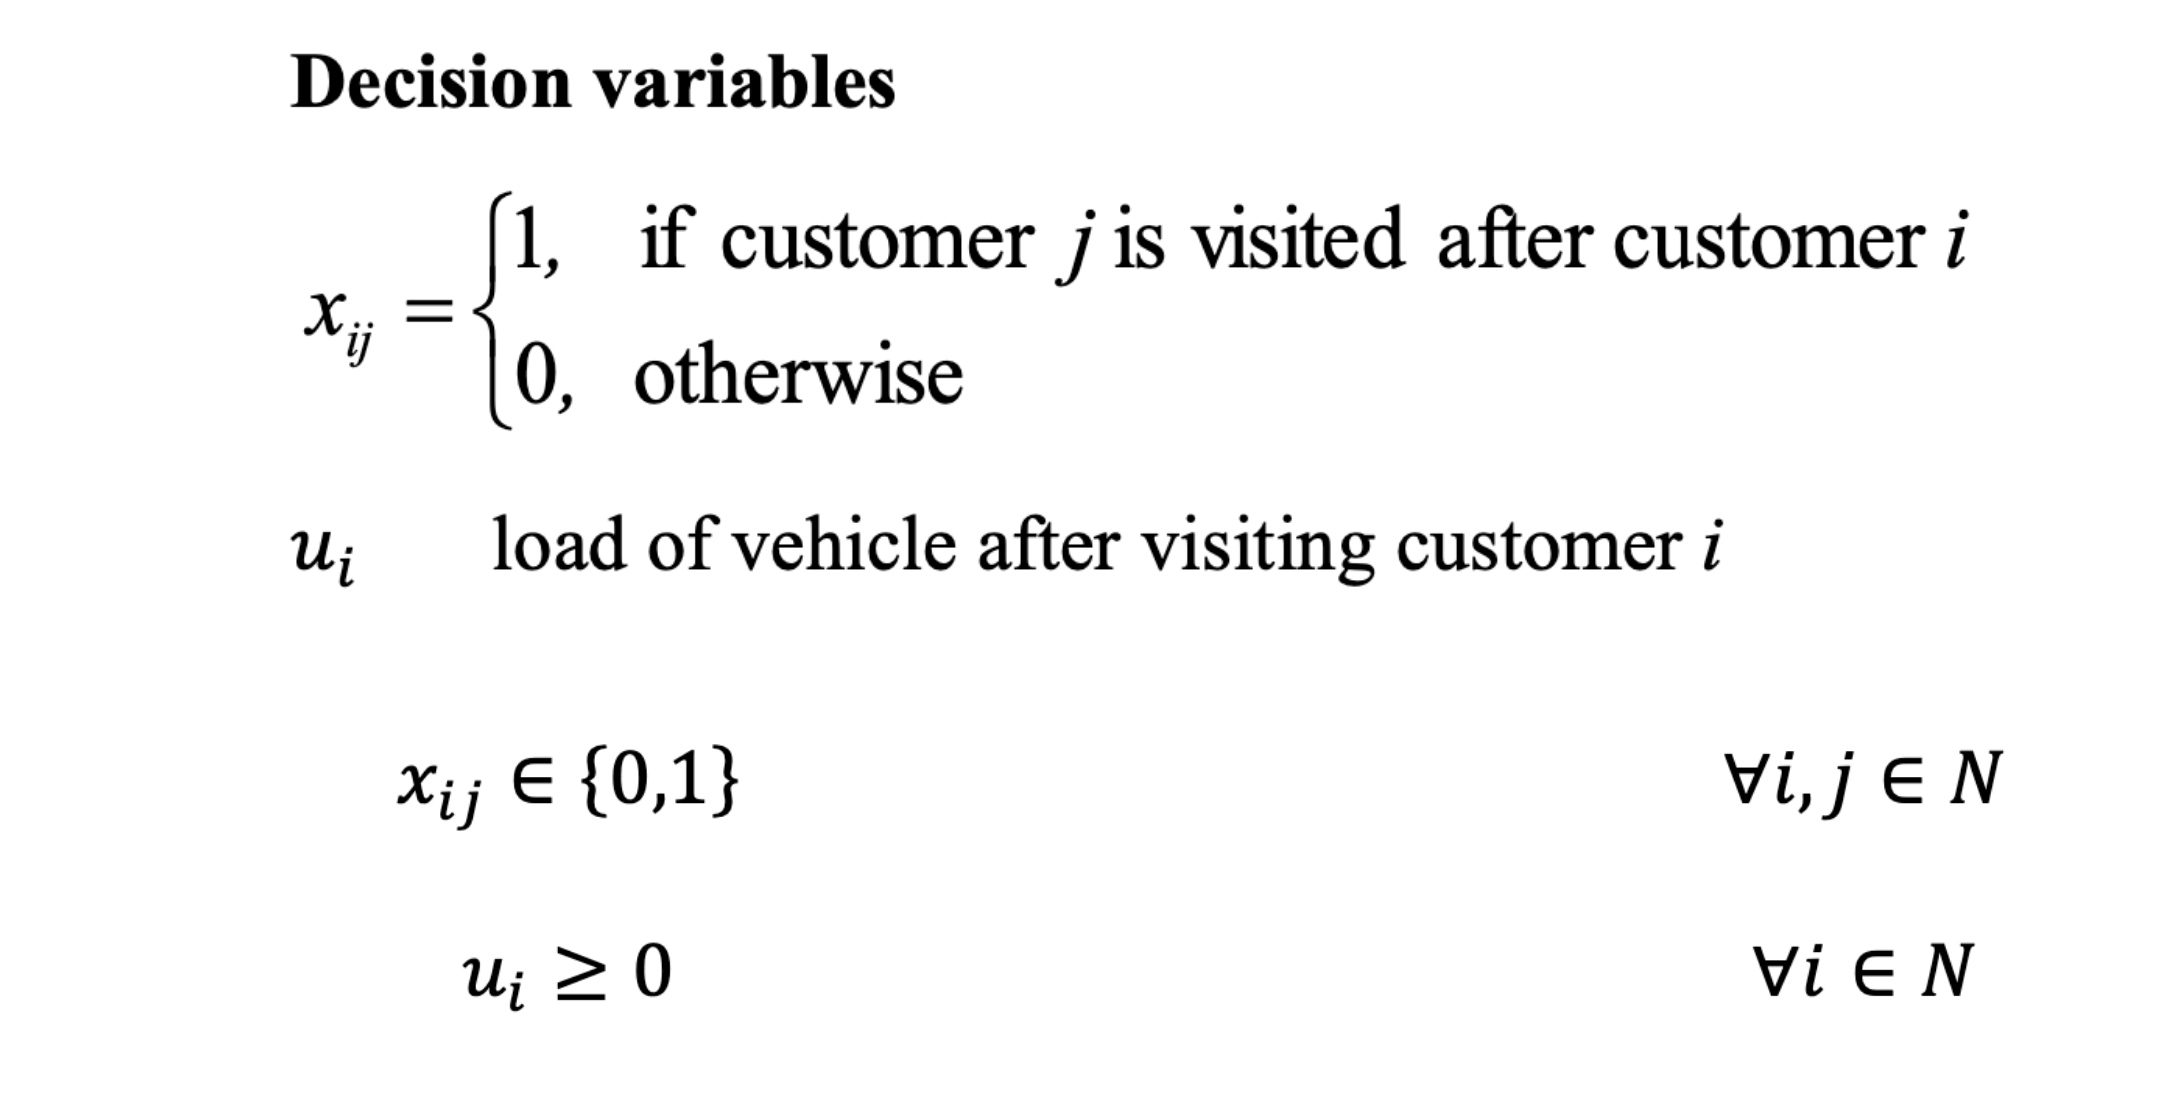

In [20]:
#Create variables
x = vrp.addVars(nodes, nodes, lb = 0,vtype = GRB.BINARY,name = 'x')
u = vrp.addVars(nodes, lb = 0,vtype = GRB.INTEGER,name = 'u')

Add constraints

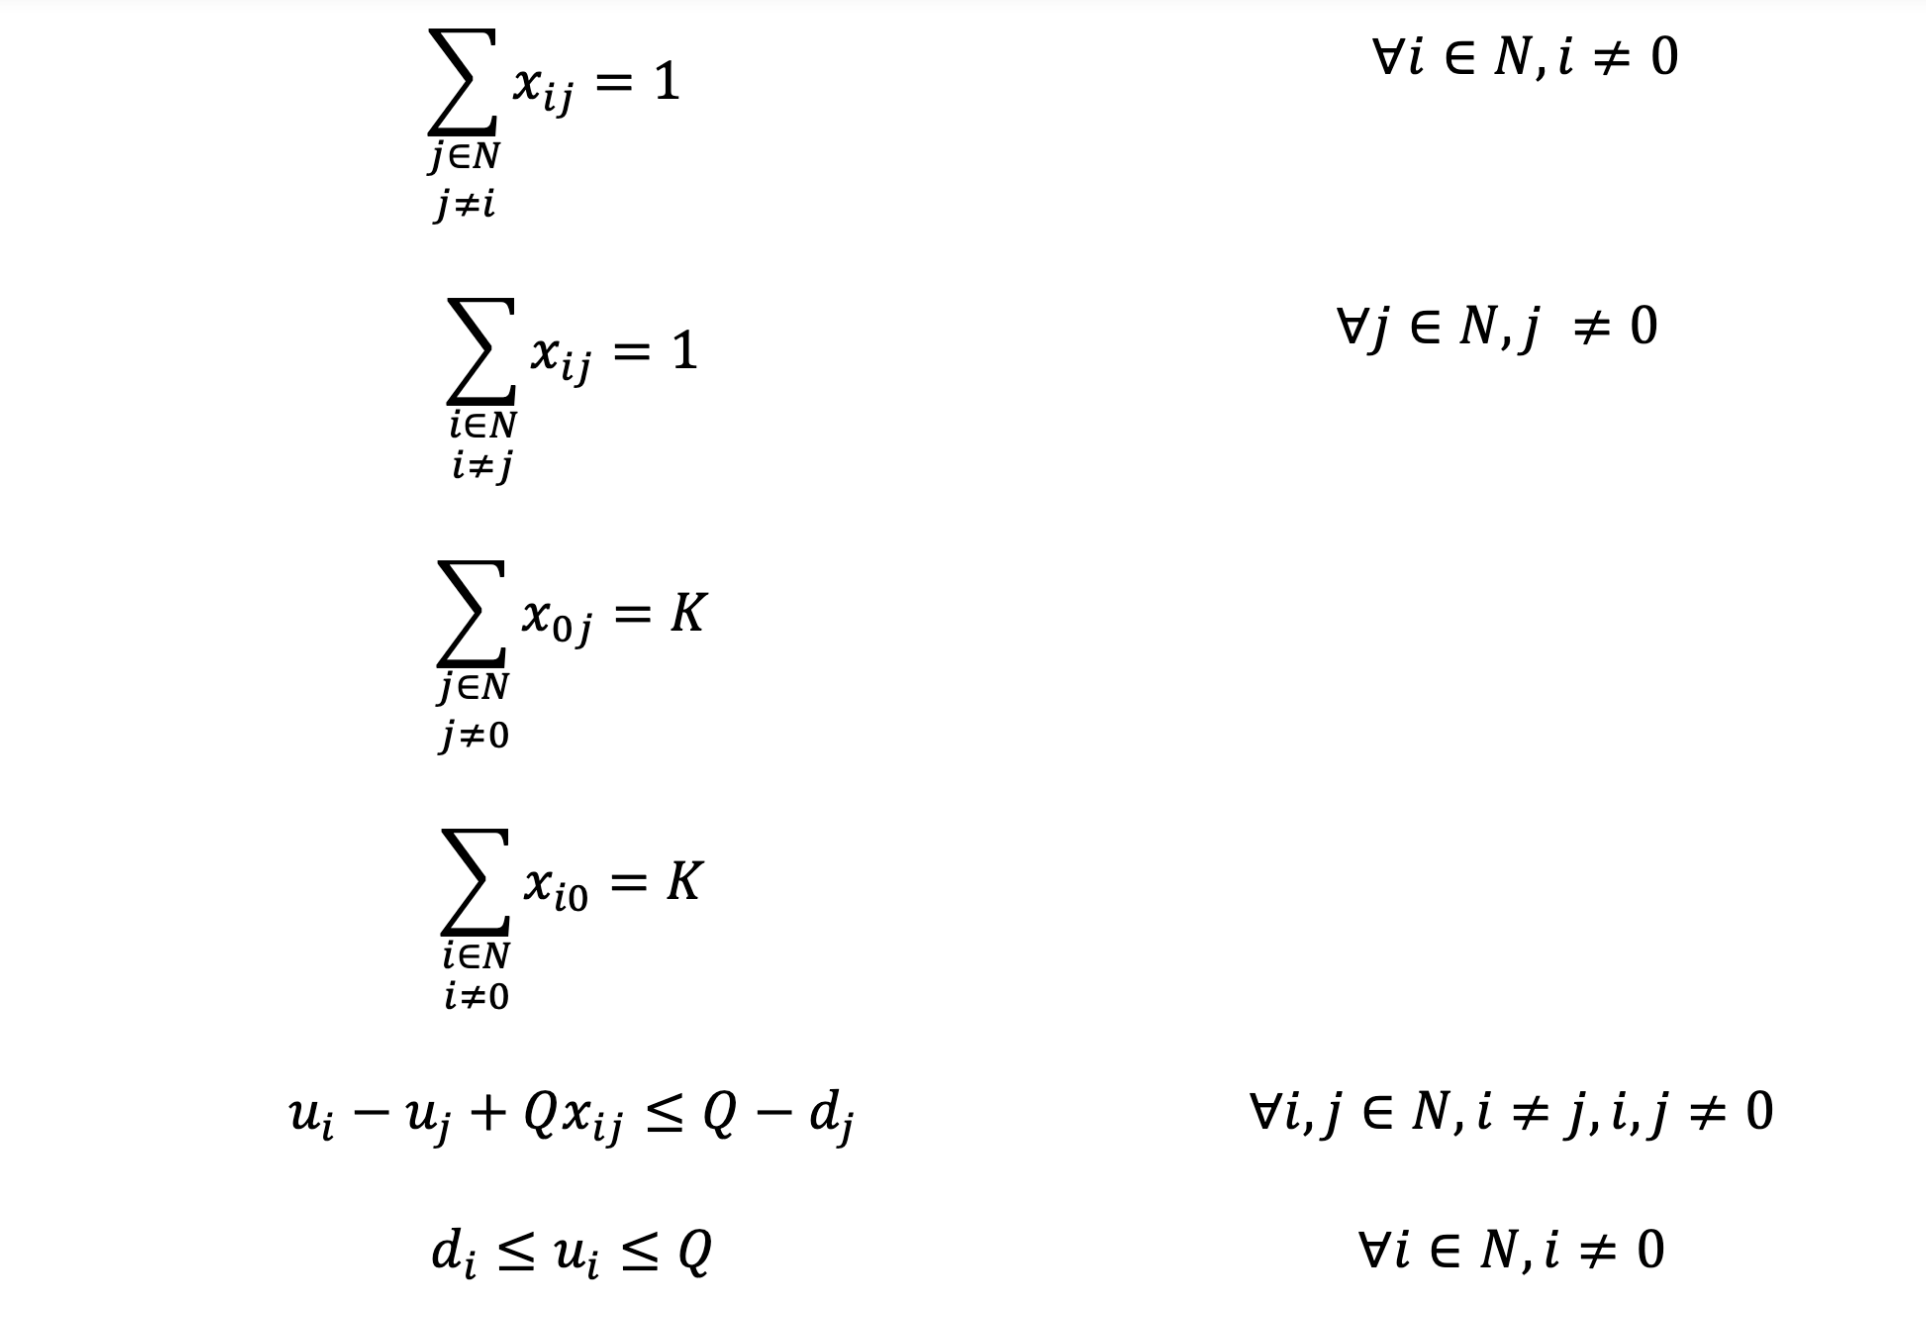

In [21]:
#Add constraint
vrp.addConstrs(((quicksum(x[i,j] for j in nodes if j != i) == 1) for i in nodes if i != 0), name = '1');
vrp.addConstrs(((quicksum(x[i,j] for i in nodes if i != j) == 1) for j in nodes if j != 0), name = '2');
vrp.addConstr(((quicksum(x[0,j] for j in nodes) == k)), name = '3');
vrp.addConstr(((quicksum(x[i,0] for i in nodes) == k)), name = '4');
vrp.addConstrs(((u[i] - u[j] + veh_cap*x[i,j] <= veh_cap - demand[j]) for i in nodes for j in nodes if i!=j and i != 0 and j != 0), name = '5');
vrp.addConstrs(((u[i] <= veh_cap) for i in nodes), name = '6');
vrp.addConstrs(((u[i] >= demand[i]) for i in nodes), name = '7');

Set objective function

In [22]:
#set objective function
vrp.setObjective((quicksum(dist[i][j]*x[i,j] for i in nodes for j in nodes if i != j)),GRB.MINIMIZE)

In [23]:
#vrp.setParam("TimeLimit", 1300)
vrp.update() # adds variables, constraints and the objective function to the model
vrp.optimize() # solves the model

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (mac64[x86] - Darwin 23.1.0 23B81)

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 994 rows, 992 columns and 4534 nonzeros
Model fingerprint: 0xa1133188
Variable types: 0 continuous, 992 integer (961 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [6e+00, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Presolve removed 62 rows and 31 columns
Presolve time: 0.03s
Presolved: 932 rows, 961 columns, 4472 nonzeros
Variable types: 0 continuous, 961 integer (931 binary)
Found heuristic solution: objective 5552.3000000

Root relaxation: objective 1.507767e+03, 108 iterations, 0.01 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 1507.76667  

I runned the gurobi for 1510s but it still could not find the optimal solution so I terminated it, I could also give a time limit

status = by checking the status code from the website https://www.gurobi.com/documentation/current/refman/optimization_status_codes.html

object_Value = objective value from the model

status 11: INTERRUPTED means Optimization was terminated by the user.

In [24]:
status = vrp.status # shows the status of our code

object_Value = vrp.objVal # stores the objective value comes from minimizing the objective function

print()
print("model status is: ", status)
print()
print("Objective value is: ", object_Value)


model status is:  11

Objective value is:  2453.4999999999995


In [27]:
# printing routes    
if status != 3 and status != 4: 
    vis = []
    Sol_x = np.zeros([len(nodes), len(nodes)])
    for i in nodes:
        for j in nodes:
            if vrp.objVal < 1e+99:
                Sol_x[i,j] = x[i,j].getAttr("X")
            else:
                error_status = True
                ofvv = 1e+99
            if 1 - 0.00001 <= Sol_x[i,j] <= 1 + 0.00001:
                vis.append((i,j))

visited = np.array(vis)
solution = []
if visited[0][0] == 0:
    sol = [visited[0][0], visited[0][1]]
elif visited[0][0] !=0 and visited[0][1] == 0:
    sol = [visited[0][1], visited[0][0]] 
else:
    print('First tuple should include depot 0')
visited = np.delete(visited,0, axis = 0)

solution = []
for i in visited:
    try:
        next_ind = int(np.where(visited[:,0] == sol[-1])[0])
        sol.append(visited[next_ind][1])
        visited = np.delete(visited,next_ind, axis = 0)
    except:
        next_ind = int(np.where(visited[:,1] == sol[-1])[0])
        sol.append(visited[next_ind][0])
        visited = np.delete(visited,next_ind, axis = 0)
    
    if sol[0] == sol[-1]:
        sol = np.asarray(sol)
        solution.append(sol)
        used = []
        for j in solution:
            for k in j:
                used.append(k)
        remain = list(set(nodes) - set(used))
        if remain == []:
            break
        sol=[visited[0][0], visited[0][1]]
        visited = np.delete(visited,0, axis = 0)



In [30]:
print(f"Gurobi's solution is {solution} with length {round(object_Value, 2)}")

Gurobi's solution is [array([ 0, 12, 21,  8, 18,  3, 10, 20,  2, 15, 29, 28, 11,  0]), array([ 0, 23, 26,  1, 24, 14,  9,  0]), array([ 0, 27, 22, 16, 13, 30,  6, 25,  7,  5, 17,  4, 19,  0])] with length 2453.5
